# Preprocessing

In questo file, provo ad analizzare le caratteristiche del dataset e a processare una singola CT e mask, nel seguente preparo il dataset da passare al modello.

Spostiamoci nella corretta working directory

In [1]:
import os
os.chdir("..")
cwd = os.getcwd()
print(cwd)

d:\kits19


Importiamo le librerie necessarie

In [2]:
from starter_code.utils import load_case
from starter_code.visualize import visualize
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import skimage.transform
from scipy.ndimage import zoom
from skimage import exposure
import cv2

# Set numpy to print only 2 decimal digits for neatness
np.set_printoptions(precision=2, suppress=True)

In [4]:
data_path = "data/case_"
imaging_fname = "/imaging.nii.gz"
segmentation_fname = "/segmentation.nii.gz"

class Patient:
    def __init__(self, number):
        self.number = number

    def get_im_data_path(self):
        out = "00000"

        out = out[len(str(self.number)):]
        out += str(self.number)
        return data_path + out + imaging_fname
    
    def get_seg_data_path(self):
        out = "00000"

        out = out[len(str(self.number)):]
        out += str(self.number)
        return data_path + out + segmentation_fname


Possiamo notare che tutte le immagini (nel dataset training) sono 512x512xZ, tranne quelle del paziente 160 (forse è conveniente lasciarlo da parte nel training)

In [3]:
for i in range(210):
    volume, segmentation = load_case(i)
    if volume.shape[1] != 512 or volume.shape[2] != 512:
        print("Pat. code {} has unusual shape: {}".format(i, volume.shape))

Pat. code 160 has unusual shape: (252, 512, 796)


Controlliamo anche il dataset per il testing (tutte le immagini sono 512x512)

In [20]:
for i in range(210, 300):
    patient = Patient(i)
    mri = nib.load(patient.get_im_data_path())

    # print(mri.shape)

    if mri.shape[1] != 512 or mri.shape[2] != 512:
        print("Pat. code {} has unusual shape: {}".format(i, mri.shape))


Osserviamo anche come varia la slice thickness nel nostro dataset.

Possiamo osservare che essa varia da 0 a 1000 e che generalmente si trovano intorno ai 50-200

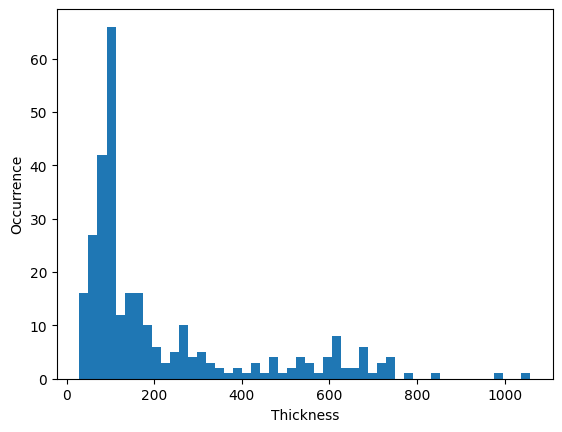

In [22]:
s_thickness_arr = []

for i in range(300):
    patient = Patient(i)
    mri = nib.load(patient.get_im_data_path())

    s_thickness_arr.append(mri.shape[0])

plt.hist(s_thickness_arr, bins=50)
plt.xlabel("Thickness")
plt.ylabel("Occurrence")

plt.show()

Guardo al contenuto dei files

Original shape:  (389, 512, 512)
Voxel dimension:  [1.25     0.869141 0.869141]


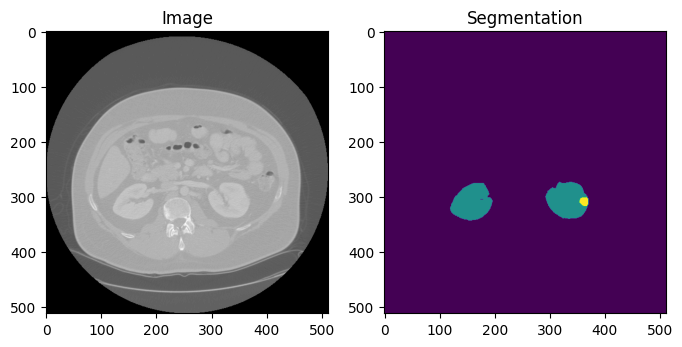

In [82]:
patient = Patient(123)

img = nib.load(patient.get_im_data_path())
seg = nib.load(patient.get_seg_data_path())

img_fig = img.get_fdata() # is a ndarray
seg_fig = seg.get_fdata()


chosen_slice = 132 # si trova a 34% di z

fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(img_fig[chosen_slice,:,:], cmap = 'gray')
plt.title("Image")

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(seg_fig[chosen_slice,:,:])
plt.title("Segmentation")

print("Original shape: ", img.shape)
print("Voxel dimension: ", img.header['pixdim'][1:4]) # is a ndarray




Ora siamo pronti a modificare voxel dims e dims per "normalizzare" il nostro dataset

L'obiettivo di questa parte è effettuare un resampling efficace, in modo tale che ciascun pixel/voxel campioni una struttura fisica in modo uniforme

Come ci è stato consigliato, portiamo tutto a dimensione comune (1,1,1)

Creiamo delle immagini isotropiche

In [48]:
vox_dim = (img.header['pixdim'][2], img.header['pixdim'][3], img.header['pixdim'][1])

target_resolution = [1, 1, 1]
scale_vector = (vox_dim[0]/target_resolution[0],
                vox_dim[1]/target_resolution[1],
                vox_dim[2]/target_resolution[2])

print(scale_vector)

isotr_img_fig = skimage.transform.rescale(img_fig, scale_vector, order=3, preserve_range=True,  mode='constant')
isotr_seg_fig = skimage.transform.rescale(seg_fig, scale_vector, order=3, preserve_range=True, mode='constant')

(0.8691409826278687, 0.8691409826278687, 1.25)


Text(0.5, 1.0, 'Old image')

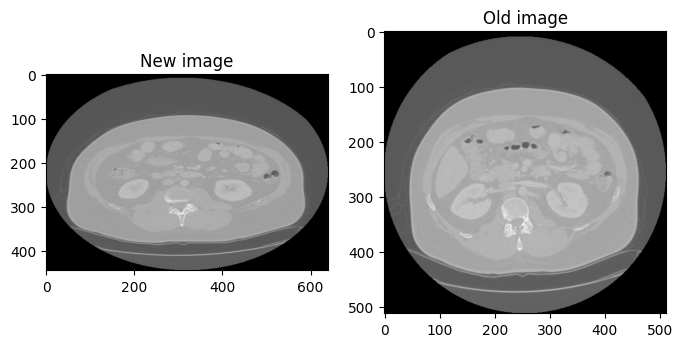

In [81]:
fig = plt.figure(figsize=(8,8))

a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(isotr_img_fig[chosen_slice,:,:], cmap = 'gray')
plt.title("New image")

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(img_fig[chosen_slice,:,:], cmap = 'gray')
plt.title("Old image")

In [83]:
print('Original image shape: ', img_fig.shape)
print('Rescaled image shape: ', isotr_img_fig.shape)

Original image shape:  (389, 512, 512)
Rescaled image shape:  (338, 445, 640)


Reshape

In [64]:
target_shape = [192, 192, 192]

factors = ( target_shape[0]/isotr_img_fig.shape[0],
            target_shape[1]/isotr_img_fig.shape[1],
            target_shape[2]/isotr_img_fig.shape[2],
            )

reshaped_iso_img_fig = zoom(isotr_img_fig, factors, order=3, mode='nearest')
reshaped_iso_seg_fig = zoom(isotr_seg_fig, factors, order=3, mode='nearest')

print("Original image shape is:", img_fig.shape)
print("Reshaped isotropic image shape is: ", reshaped_iso_img_fig.shape)


Original image shape is: (389, 512, 512)
Reshaped isotropic image shape is:  (192, 192, 192)


66


Text(0.5, 1.0, 'Original seg.')

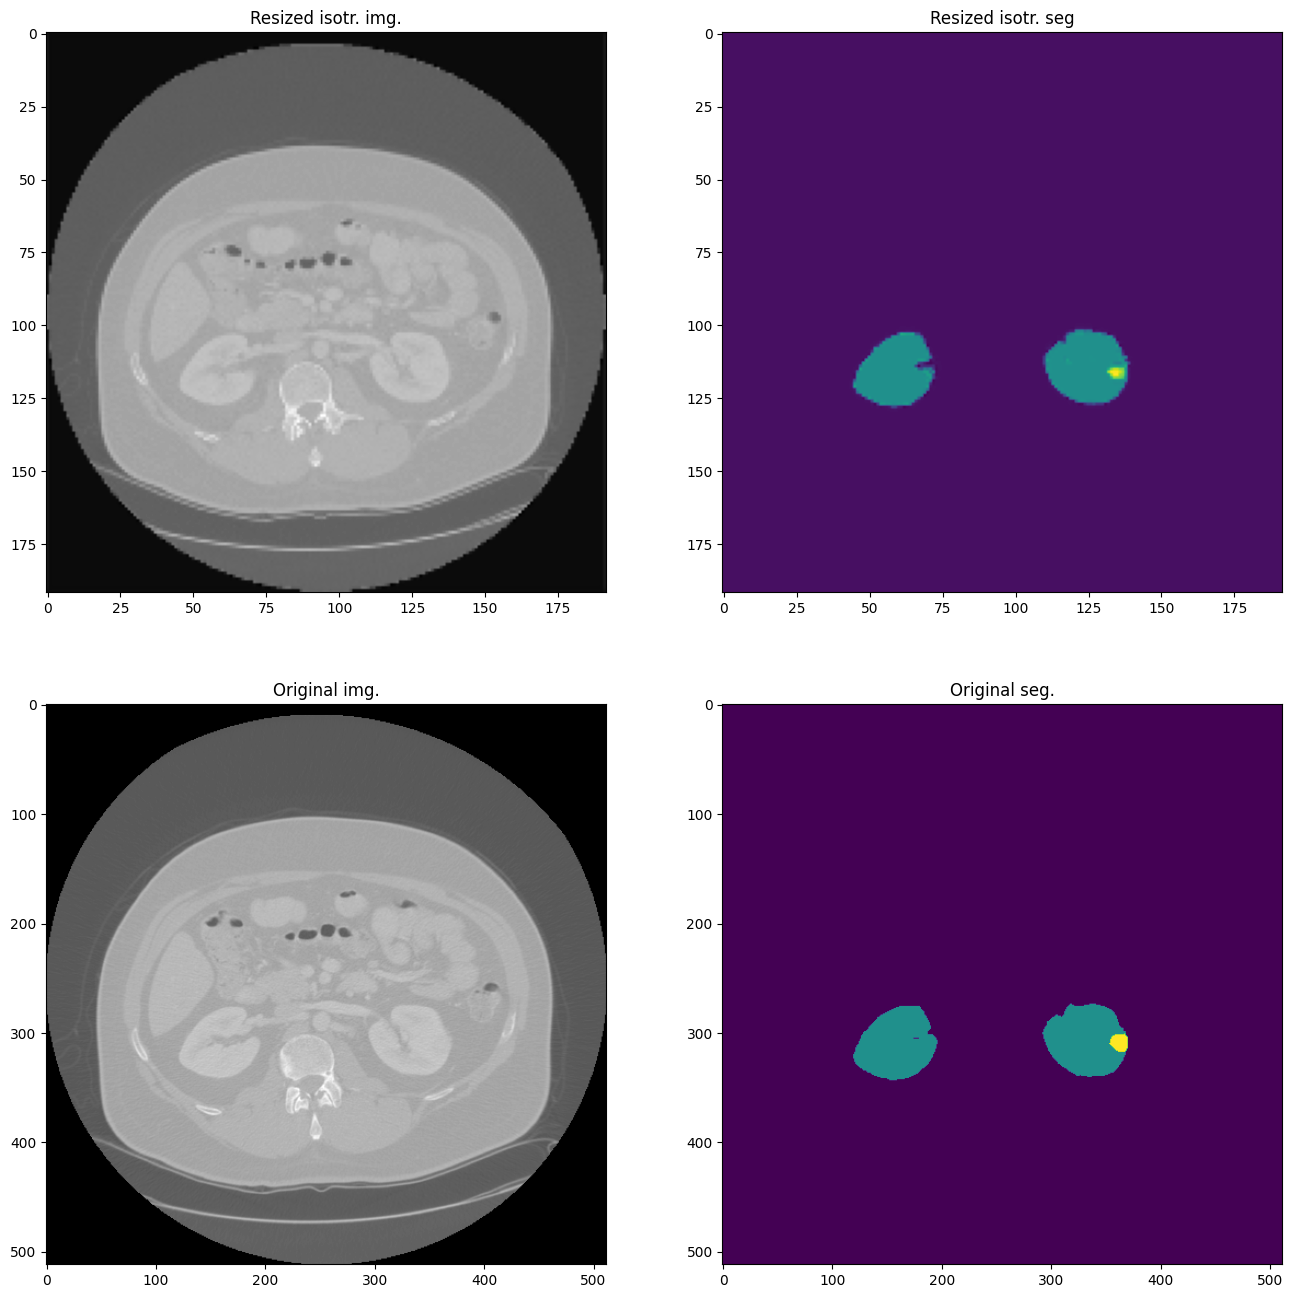

In [85]:
chosen_slice_adjusted = int(0.34*196)
print(chosen_slice_adjusted)

fig = plt.figure(figsize=(16,16))
a = fig.add_subplot(2,2,1)
imgplot = plt.imshow(reshaped_iso_img_fig [chosen_slice_adjusted, :, :], cmap = 'gray')
plt.title("Resized isotr. img.")

a = fig.add_subplot(2,2,2)
imgplot = plt.imshow(reshaped_iso_seg_fig[chosen_slice_adjusted, :, :])
plt.title("Resized isotr. seg")

a = fig.add_subplot(2,2,3)
imgplot = plt.imshow(img_fig[chosen_slice, :, :], cmap = 'gray')
plt.title("Original img.")

a = fig.add_subplot(2,2,4)
imgplot = plt.imshow(seg_fig[chosen_slice, :, :])
plt.title("Original seg.")

In [72]:
print("Reshaped isotropic imaging figure size: ", reshaped_iso_img_fig.shape)
print("Reshaped isotropic segmentation figure size: ", reshaped_iso_seg_fig.shape)

Reshaped isotropic imaging figure size:  (192, 192, 192)
Reshaped isotropic segmentation figure size:  (192, 192, 192)
[[ 0.          0.         -0.86914098  0.        ]
 [ 0.         -0.86914098  0.          0.        ]
 [-1.25        0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [ ]:
# rr = rescaled and reshaped
# rr_img = nib.Nifti1Image(reshaped_iso_img_fig, img.affine)
# rr_seg = nib.Nifti1Image(reshaped_iso_seg_fig, seg.affine)

# print(type(img.affine))
# # c'è qualcosa di strano, le nuove immagini non sembrano essere isotropiche
# # setto le dimensioni manualmente, sono abbastanza sicuro che il rescaling sia avvenuto correttamente

# rr_img.header['pixdim'][1:4] = [1,1,1]
# rr_seg.header['pixdim'][1:4] = [1,1,1]

# print("New voxel dimensions in imaging figure: ", rr_img.header['pixdim'][1:4])
# print("New voxel in segmentation figure: ", rr_seg.header['pixdim'][1:4])

# print(rr_img.affine)
# print(rr_seg.header)



Questo processo dovra essere applicato su tutte le immagini del nostro dataset

---

Ora analizzo l'image histogram dello stesso paziente

Text(0.5, 1.0, 'Image Histogram')

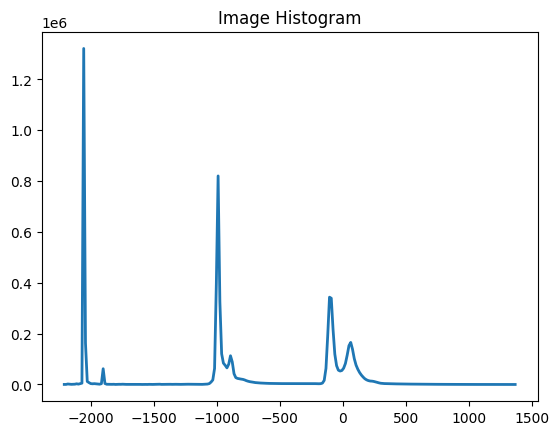

In [133]:
rr_img_fig = rr_img.get_fdata()

hist, bins_center = exposure.histogram(rr_img_fig)
plt.plot(bins_center, hist, lw=2)
plt.title("Image Histogram")

# negative values represent voxels outside the body

In questo specifico caso, i voxel non appartenenti all'immagine hanno un valore di -2048 e altri con -1000, sarebbe bello vedere come questo varia all'interno del nostro dataset, sperando che questa convenzione sia rispettata in ogni imaging

In [134]:
vox_val_ranges = []

for i in range(300):
    
    patient = Patient(i)

    img = nib.load(patient.get_im_data_path())
    img_fig = img.get_fdata()

    vox_range = [np.min(img_fig), np.max(img_fig)]

    vox_val_ranges.append(vox_range)

print(len(vox_val_ranges))

300


Text(0.5, 1.0, 'Voxel val range (no outliers)')

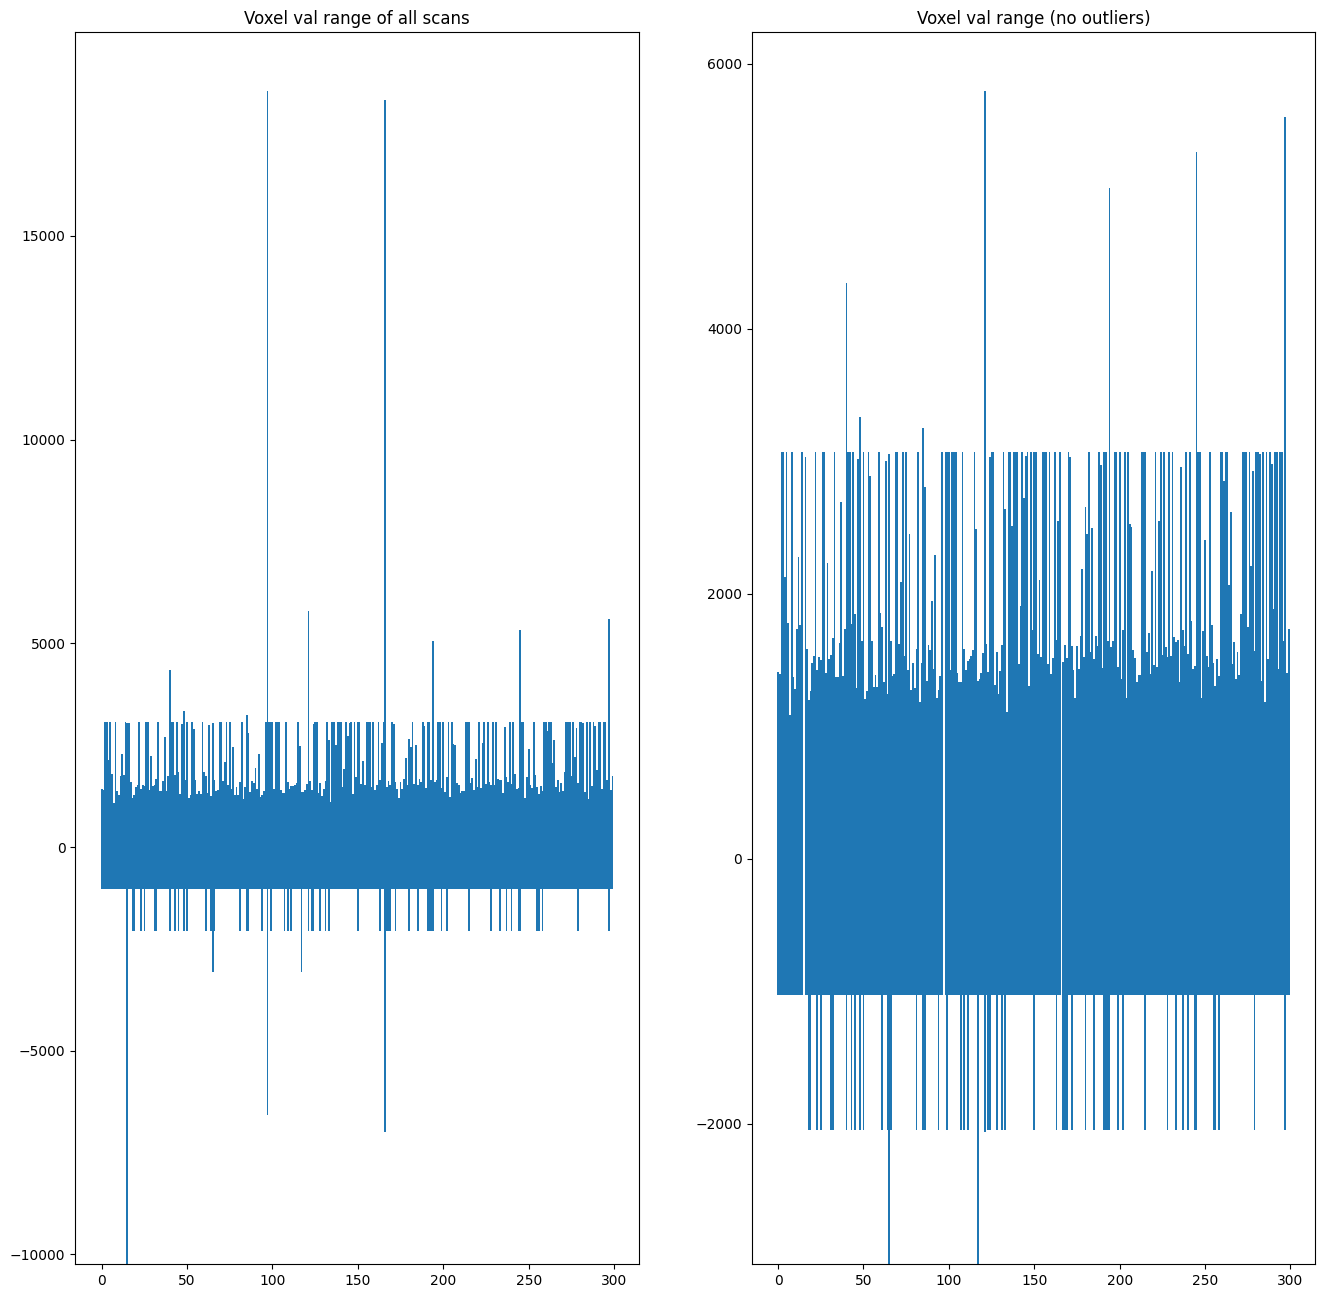

In [144]:
indexes = np.arange(0,300).tolist()

vox_deltas = [range[1]-range[0] for range in vox_val_ranges]
min_vox_vals = [range[0] for range in vox_val_ranges]

# lists with outliers removed
vox_deltas_no_out = []
min_vox_vals_no_out = []

for range in vox_val_ranges:
    if range[0]<-5000 or range[1]>10_000:
        vox_deltas_no_out.append(0)
        min_vox_vals_no_out.append(0)
    else:
        vox_deltas_no_out.append(range[1]-range[0])
        min_vox_vals_no_out.append(range[0])
##

fig = plt.figure(figsize=(16,16))
width = 1

fig.add_subplot(1,2,1)
plt.bar(indexes, vox_deltas, width=width, bottom=min_vox_vals)
plt.title("Voxel val range of all scans")

fig.add_subplot(1,2,2)
plt.bar(indexes, vox_deltas_no_out, width=width, bottom=min_vox_vals_no_out)
plt.title("Voxel val range (no outliers)")

Dai grafici vediamo che:
- alcuni outliers hanno valori che scendono fino ai -10_000 e salgono fino ai 15_000
- la maggior parte va da -1xxx a 1500-3000
- una minoranza scende fino ai -2048 (come nel caso pat.123)
- valori negativi corrispondono a background (come da convenzione)

In ogni caso, provo a normalizzare la singola immagine del paziente 123

In [147]:
norm_image = cv2.normalize(rr_img_fig, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)
clahe = cv2.createCLAHE (clipLimit = 2.0, tileGridSize = (8, 8))
clahe_image = clahe.apply(norm_image[chosen_slice, :, :])


In [152]:
print(np.max(norm_image))
print(np.min(norm_image))

255
0


Text(0.5, 1.0, 'Clahed image')

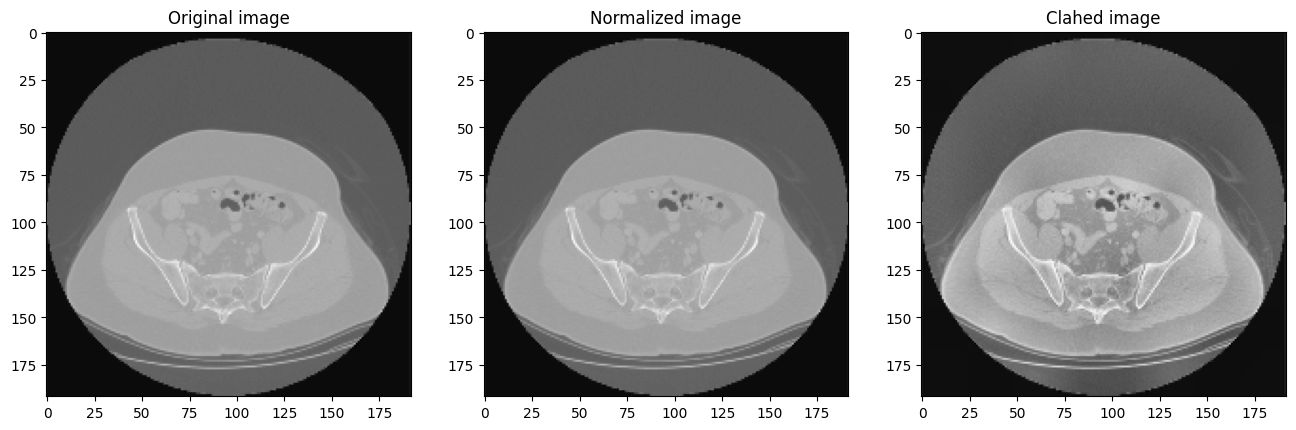

In [150]:
fig = plt.figure(figsize=(16,16))

a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(rr_img_fig[chosen_slice, :, :], cmap = 'gray')
plt.title("Original image")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(norm_image[chosen_slice, :, :], cmap = 'gray')
plt.title("Normalized image")

a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(clahe_image, cmap = 'gray')
plt.title("Clahed image")

Come visto nelle lezioni, la clahe migliora il risultato

---
Buttiamo giù delle funzioni da dover applicare su tutto il dataset per processarlo

In [5]:
def rr_img(nifti_img, target_resolution=[1,1,1], target_shape=[192,192,192]):
    '''
    Function that returns reshaped and resized fig of a nifti img
    ''' 

    # x,y,z
    vox_dim = (nifti_img.header['pixdim'][2], nifti_img.header['pixdim'][3], nifti_img.header['pixdim'][1])

    scale_vector = (vox_dim[0]/target_resolution[0],
                    vox_dim[1]/target_resolution[1],
                    vox_dim[2]/target_resolution[2])

    img_fig = nifti_img.get_fdata()

    isotr_img_fig = skimage.transform.rescale(img_fig, scale_vector, order=3, preserve_range=True,  mode='constant')

    factors = ( target_shape[0]/isotr_img_fig.shape[0],
                target_shape[1]/isotr_img_fig.shape[1],
                target_shape[2]/isotr_img_fig.shape[2],)

    reshaped_iso_img_fig = zoom(isotr_img_fig, factors, order=3, mode='nearest')

    return reshaped_iso_img_fig

In [ ]:
patient1 = Patient(1)
pat1_img = nib.load(patient1.get_im_data_path())

pat1_rr_img = rr_img(pat1_img)
pat1_rrn_img = cv2.normalize(pat1_rr_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)

fig = plt.figure(figsize=(16,16))
plt.imshow(pat1_rrn_img[96,:,:], cmap='gray')